In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import scipy
import sklearn
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
file_train= r'../data/UNSW_NB15_testing-set.csv'
file_test= r'../data/UNSW_NB15_training-set.csv'

# Data Processing

load files

In [3]:
df_train = pd.read_csv(file_train)
df_test = pd.read_csv(file_test)
print("training:",df_train.shape,"testing:",df_test.shape)
print(df_train.head())
print(df_test.head())


training: (175341, 45) testing: (82332, 45)
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips

checking normal data and attack data ratio in training file


In [4]:
print(df_train.label.value_counts())
print("Attack : Normal :",round(df_train.label.value_counts()[1]/df_train.shape[0],2),":",round(df_train.label.value_counts()[0]/df_train.shape[0],2))
# this is acceptable ratio for training data, as we would like to know more about the attacking data
print(df_test.label.value_counts())
print("Attack : Normal :",round(df_test.label.value_counts()[1]/df_test.shape[0],2),":",round(df_test.label.value_counts()[0]/df_test.shape[0],2))


1    119341
0     56000
Name: label, dtype: int64
Attack : Normal : 0.68 : 0.32
1    45332
0    37000
Name: label, dtype: int64
Attack : Normal : 0.55 : 0.45


In [5]:
df_train = df_train.replace("-",np.nan)
df_train = df_train.dropna(axis=0)
df_test = df_test.replace("-",np.nan)
df_test = df_test.dropna(axis=0)

## one hot encoding

In [6]:
#use get dummies to create new attributes
num_col = df_train.select_dtypes(include='number').columns
cat_col = df_train.columns.difference(num_col)
cat_col = cat_col[1:]


data_cat = df_train[cat_col].copy()
data_cat = pd.get_dummies(data_cat,columns=cat_col)
df_train = pd.concat([df_train, data_cat],axis=1)
df_train.drop(columns=cat_col,inplace=True)
print(df_train.shape)

data_cat = df_test[cat_col].copy()
data_cat = pd.get_dummies(data_cat,columns=cat_col)
df_test = pd.concat([df_test, data_cat],axis=1)
df_test.drop(columns=cat_col,inplace=True)
print(df_test.shape)

(81173, 61)
(35179, 61)


## column diff deleting

In [7]:
# selecting numeric attributes columns from data
num_col_train = list(df_train.select_dtypes(include='number').columns)
num_col_train.remove('id')
num_col_train.remove('label')
print(num_col_train)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_tcp', 'proto_udp', 'service_dhcp', 'service_dns', 'service_ftp', 'service_ftp-data', 'service_http', 'service_irc', 'service_pop3', 'service_radius', 'service_smtp', 'service_snmp', 'service_ssh', 'service_ssl', 'state_CON', 'state_FIN', 'state_INT', 'state_REQ', 'state_RST']


In [8]:
num_col_test = list(df_test.select_dtypes(include='number').columns)
num_col_test.remove('id')
num_col_test.remove('label')
print(num_col_test)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_tcp', 'proto_udp', 'service_dhcp', 'service_dns', 'service_ftp', 'service_ftp-data', 'service_http', 'service_irc', 'service_pop3', 'service_radius', 'service_smtp', 'service_snmp', 'service_ssh', 'service_ssl', 'state_ACC', 'state_CON', 'state_FIN', 'state_INT', 'state_REQ']


In [9]:
#as two file has different valueable in state, so remove the different column
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
diff = Diff(num_col_train,num_col_test)
print(diff)
for i in diff:
    if i in num_col_train:
        num_col_train.remove(i)
        df_train = df_train.drop(columns=[i],axis=1)
    else:
        num_col_test.remove(i)
        df_test = df_test.drop(columns=[i],axis=1)

['state_RST', 'state_ACC']


In [10]:
#add label back
num_col_train.append('label')
num_col_test.append('label')

## Correlation

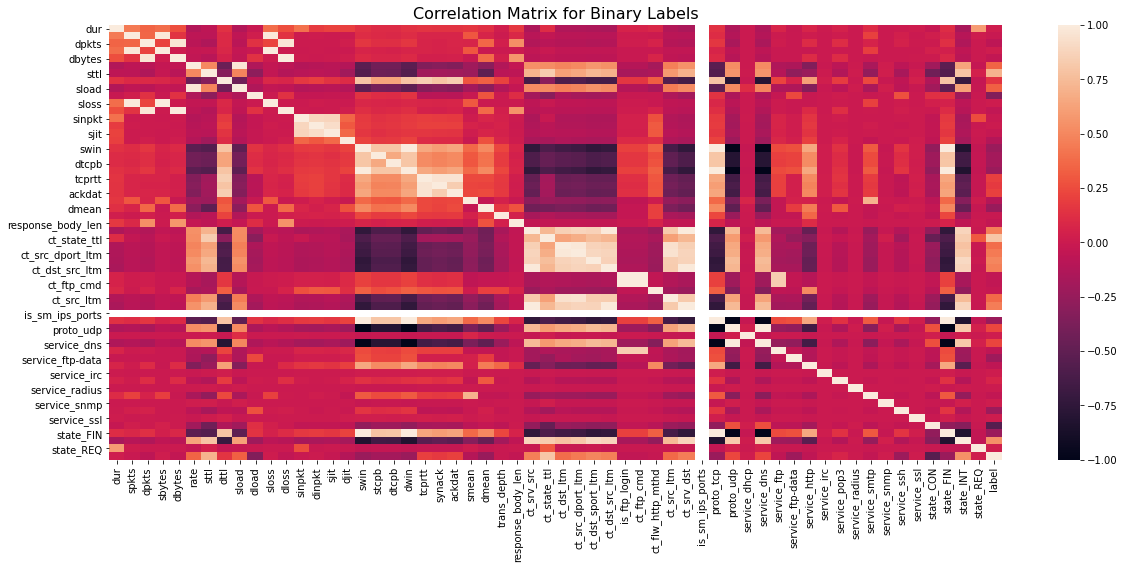

In [11]:
# Correlation Matrix for the training data
plt.figure(figsize=(20,8))
corr_train_bin = df_train[num_col_train].corr()
sns.heatmap(corr_train_bin,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
plt.show()

## Feature Selection

In [12]:
# finding the features which have more than 0.3 correlation 
corr_ybin = abs(corr_train_bin['label'])
highest_corr_bin = corr_ybin[corr_ybin >0.3]
highest_corr_bin.sort_values(ascending=True)

sload               0.334562
dload               0.343910
rate                0.344535
ct_src_ltm          0.368486
ct_dst_ltm          0.387358
ct_src_dport_ltm    0.444874
ct_srv_dst          0.459984
ct_srv_src          0.463153
ct_dst_src_ltm      0.463735
ct_dst_sport_ltm    0.497234
state_INT           0.546631
state_CON           0.552505
sttl                0.707337
ct_state_ttl        0.801403
label               1.000000
Name: label, dtype: float64

In [13]:
bin_cols = highest_corr_bin.index

In [14]:
#select features 
df_train = df_train[bin_cols].copy()
print(df_train['label'].value_counts())

df_test = df_test[bin_cols].copy()
print(df_test['label'].value_counts())

1    61685
0    19488
Name: label, dtype: int64
1    25554
0     9625
Name: label, dtype: int64


In [15]:
print(df_train.shape)
print(df_test.shape)
diff = Diff(df_test.columns,df_train.columns)
print(diff,"\n",df_test.columns,"\n",df_train.columns)

(81173, 15)
(35179, 15)
[] 
 Index(['rate', 'sttl', 'sload', 'dload', 'ct_srv_src', 'ct_state_ttl',
       'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_src_ltm', 'ct_srv_dst', 'state_CON', 'state_INT', 'label'],
      dtype='object') 
 Index(['rate', 'sttl', 'sload', 'dload', 'ct_srv_src', 'ct_state_ttl',
       'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_src_ltm', 'ct_srv_dst', 'state_CON', 'state_INT', 'label'],
      dtype='object')


In [16]:
#split the data
X_train = df_train.drop(['label'], axis=1) # drop the column with the target/unnecessary variables
X_test = df_test.drop(['label',], axis=1)# drop the column with the target/unnecessary variables
y_train = df_train[['label']] # target
y_test = df_test[['label']]# target

In [17]:
# performing train test split
print("Creating training and test sets")
print(X_train.shape[0], "samples in training set")
print(X_test.shape[0], "samples in test set")

Creating training and test sets
81173 samples in training set
35179 samples in test set


# Model Building

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve as rc
from sklearn.metrics import confusion_matrix as cm

In [19]:
#set random state
random_state = 44777717

## Decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [21]:
#parameter to be tuned
splitter=["best","random"]
max_depth=[1,2, 3, 5, 7,10, 20]
criterion= ["gini", "entropy"]

### Baseline Model

In [22]:
DTC = DecisionTreeClassifier(random_state=random_state)
_start_time = time.time()
DTC.fit(X_train,y_train)
print("Training time",time.time() - _start_time,"seconds")

print('Trained Accuracy: {:.2f}%'.format(DTC.score(X_train, y_train)*100))
print('Accuracy: {:.2f}%'.format(DTC.score(X_test, y_test)*100))

_start_time = time.time()
pred_result = DTC.predict(X_test)
print("Predict time",time.time() - _start_time,"seconds")

print(classification_report(y_test, pred_result))

Training time 0.1527717113494873 seconds
Trained Accuracy: 100.00%
Accuracy: 94.72%
Predict time 0.0049593448638916016 seconds
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      9625
           1       0.94      0.99      0.96     25554

    accuracy                           0.95     35179
   macro avg       0.95      0.91      0.93     35179
weighted avg       0.95      0.95      0.95     35179



### Tuning

In [23]:
print("splitter max_depth criterion test train")
for i in splitter:
    for j in max_depth:
        for k in criterion:
            DTC = DecisionTreeClassifier(criterion=k,max_depth=j,splitter=i,random_state=random_state)
            DTC.fit(X_train,y_train)
            print(i,j,k,'{:.4f}'.format(DTC.score(X_test, y_test)),'{:.4f}'.format(DTC.score(X_train, y_train)))

splitter max_depth criterion test train
best 1 gini 0.9205 0.9782
best 1 entropy 0.9205 0.9782
best 2 gini 0.9205 0.9782
best 2 entropy 0.9205 0.9782
best 3 gini 0.9205 0.9782
best 3 entropy 0.9205 0.9782
best 5 gini 0.9640 0.9793
best 5 entropy 0.9196 0.9785
best 7 gini 0.9444 0.9821
best 7 entropy 0.9685 0.9805
best 10 gini 0.9449 0.9847
best 10 entropy 0.9472 0.9832
best 20 gini 0.9480 0.9967
best 20 entropy 0.9523 0.9950
random 1 gini 0.8527 0.8194
random 1 entropy 0.8527 0.8194
random 2 gini 0.9198 0.9781
random 2 entropy 0.9198 0.9781
random 3 gini 0.9198 0.9781
random 3 entropy 0.9198 0.9781
random 5 gini 0.9271 0.9785
random 5 entropy 0.9271 0.9785
random 7 gini 0.9383 0.9797
random 7 entropy 0.9382 0.9798
random 10 gini 0.9453 0.9820
random 10 entropy 0.9434 0.9821
random 20 gini 0.9516 0.9913
random 20 entropy 0.9458 0.9914


### Final Model

In [24]:
#picked criterion as entropy, max depth as 7 and splitter as best
DTC = DecisionTreeClassifier(
                            criterion='entropy',
                            max_depth=7,
                            splitter='best',
                            random_state=random_state
)
#confusion matrix data
_start_time = time.time()
DTC.fit(X_train, y_train)
train_time = round(time.time() - _start_time,2)
print("Train_time:",train_time)
_start_time = time.time()
pred_result = DTC.predict(X_test)
print('prediction_time:',round(time.time() - _start_time,2))
print('Trained_accuracy',round(DTC.score(X_train, y_train)*100,2))
print('Testing_accuracy',round(DTC.score(X_test, y_test) * 100,2))

cf_matrix = cm(y_test, pred_result)
tn, fp, fn, tp = cm(y_test, pred_result).ravel()
print('TN',tn)
print('FP',fp)
print('FN',fn)
print('TP',tp)
print('Precision',round(tp/(tp+fp)*100, 2))
print('recall',round(tp/(tp+fn)*100, 2))
print('fpr',round(fp/(fp+tn)*100, 2))
print('fnr',round(fn/(fn+tp)*100, 2))
print('tnr',round(tn/(tn+fp)*100, 2))
print('npv',round(tn/(tn+fn)*100, 2))
print('fdr',round(fp/(fp+tp)*100, 2))
print('for',round(fn/(fn+tn)*100, 2))
print('f1',round(((2*tp)/(2*tp+fp+fn))*100, 2))


Train_time: 0.11
prediction_time: 0.0
Trained_accuracy 98.05
Testing_accuracy 96.85
TN 8657
FP 968
FN 139
TP 25415
Precision 96.33
recall 99.46
fpr 10.06
fnr 0.54
tnr 89.94
npv 98.42
fdr 3.67
for 1.58
f1 97.87


# Random Forests 

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
#parameter to be tuned
bootstrap=[True, False]
max_depth= [2, 3, 5, 7,10, 20]
max_features= ['auto', 'sqrt']
n_estimators=[10, 50, 100, 150,  500, 700, 1000]

# Basline Model

In [27]:
RFC=RandomForestClassifier(random_state=random_state)
_start_time = time.time()
RFC.fit(X_train, y_train)
print("Training time",time.time() - _start_time,"seconds")

print('Trained Accuracy: {:.2f}%'.format(RFC.score(X_train, y_train)*100))
print('Accuracy: {:.2f}%'.format(RFC.score(X_test, y_test)*100))

_start_time = time.time()
pred = RFC.predict(X_test)
print("Predict time",time.time() - _start_time,"seconds")

print(classification_report(y_test, pred))

Training time 2.7666866779327393 seconds
Trained Accuracy: 100.00%
Accuracy: 95.22%
Predict time 0.18699336051940918 seconds
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      9625
           1       0.94      1.00      0.97     25554

    accuracy                           0.95     35179
   macro avg       0.97      0.91      0.94     35179
weighted avg       0.95      0.95      0.95     35179



### Tuning

In [28]:
print("bootstrap max_depth max_features n_estimators test train")
for i in bootstrap:
    for j in max_depth:
        for k in max_features:
            for l in n_estimators:
                RFC = RandomForestClassifier(max_features=k,max_depth=j,bootstrap=i,n_estimators=l,random_state=random_state)
                RFC.fit(X_train,y_train)
                print(i,j,k,l,'{:.4f}'.format(RFC.score(X_test, y_test)),'{:.4f}'.format(RFC.score(X_train, y_train)))

bootstrap max_depth max_features n_estimators test train
True 2 auto 10 0.9201 0.9775
True 2 auto 50 0.9205 0.9782
True 2 auto 100 0.9204 0.9781
True 2 auto 150 0.9205 0.9781
True 2 auto 500 0.9205 0.9782
True 2 auto 700 0.9205 0.9782
True 2 auto 1000 0.9205 0.9782
True 2 sqrt 10 0.9201 0.9775
True 2 sqrt 50 0.9205 0.9782
True 2 sqrt 100 0.9204 0.9781
True 2 sqrt 150 0.9205 0.9781
True 2 sqrt 500 0.9205 0.9782
True 2 sqrt 700 0.9205 0.9782
True 2 sqrt 1000 0.9205 0.9782
True 3 auto 10 0.9197 0.9781
True 3 auto 50 0.9205 0.9786
True 3 auto 100 0.9205 0.9786
True 3 auto 150 0.9205 0.9786
True 3 auto 500 0.9205 0.9783
True 3 auto 700 0.9205 0.9786
True 3 auto 1000 0.9205 0.9782
True 3 sqrt 10 0.9197 0.9781
True 3 sqrt 50 0.9205 0.9786
True 3 sqrt 100 0.9205 0.9786
True 3 sqrt 150 0.9205 0.9786
True 3 sqrt 500 0.9205 0.9783
True 3 sqrt 700 0.9205 0.9786
True 3 sqrt 1000 0.9205 0.9782
True 5 auto 10 0.9204 0.9785
True 5 auto 50 0.9205 0.9786
True 5 auto 100 0.9205 0.9786
True 5 auto 150 0.9

### Final Model

In [29]:
#picked bootstrap as false, max depth as 20, max_features as auto, n estimator as 500
RFC=RandomForestClassifier(
                        bootstrap=False,
                        max_depth=20,
                        max_features='auto',
                        n_estimators=500,
                        random_state=random_state
)
#confusion matrix data
_start_time = time.time()
RFC.fit(X_train, y_train)
train_time = round(time.time() - _start_time,2)
print("Train_time:",train_time)
_start_time = time.time()
pred_result = RFC.predict(X_test)
print('prediction_time:',round(time.time() - _start_time,2))
print('Trained_accuracy',round(RFC.score(X_train, y_train)*100,2))
print('Testing_accuracy',round(RFC.score(X_test, y_test) * 100,2))
cf_matrix = cm(y_test, pred_result)
tn, fp, fn, tp = cm(y_test, pred_result).ravel()
print('TN',tn)
print('FP',fp)
print('FN',fn)
print('TP',tp)
print('Precision',round(tp/(tp+fp)*100, 2))
print('recall',round(tp/(tp+fn)*100, 2))
print('fpr',round(fp/(fp+tn)*100, 2))
print('fnr',round(fn/(fn+tp)*100, 2))
print('tnr',round(tn/(tn+fp)*100, 2))
print('npv',round(tn/(tn+fn)*100, 2))
print('fdr',round(fp/(fp+tp)*100, 2))
print('for',round(fn/(fn+tn)*100, 2))
print('f1',round(((2*tp)/(2*tp+fp+fn))*100, 2))


Train_time: 18.25
prediction_time: 0.87
Trained_accuracy 99.71
Testing_accuracy 95.42
TN 8046
FP 1579
FN 33
TP 25521
Precision 94.17
recall 99.87
fpr 16.41
fnr 0.13
tnr 83.59
npv 99.59
fdr 5.83
for 0.41
f1 96.94


## Gradient-boosted tree

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [31]:
#parameter to be tuned
learning_rate = [0.05,0.1,0.2,0.3,0.35,0.4]
n_estimators = [100, 150, 300, 500, 700]
max_depth = [1,3,5,7,9]

### Baseline Model

In [32]:
GB = GradientBoostingClassifier(random_state=random_state)
_start_time = time.time()
GB.fit(X_train,y_train)
print("Training time",time.time() - _start_time,"seconds")

print('Trained Accuracy: {:.2f}%'.format(GB.score(X_train, y_train)*100))
print('Accuracy: {:.2f}%'.format(GB.score(X_test, y_test)*100))

_start_time = time.time()
pred_result = GB.predict(X_test)
print("Predict time",time.time() - _start_time,"seconds")

print(classification_report(y_test, pred_result))

Training time 6.311039924621582 seconds
Trained Accuracy: 98.30%
Accuracy: 94.16%
Predict time 0.026286602020263672 seconds
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      9625
           1       0.93      1.00      0.96     25554

    accuracy                           0.94     35179
   macro avg       0.96      0.90      0.92     35179
weighted avg       0.94      0.94      0.94     35179



### Tune parameter

In [33]:
print("learning_rate n_estimators max_depth test train")
for i in learning_rate:
    for j in max_depth:
        for k in n_estimators:
            GB = GradientBoostingClassifier(learning_rate=i,max_depth=j,n_estimators=k,random_state=random_state)
            GB.fit(X_train,y_train)
            print(i,j,k,'{:.4f}'.format(GB.score(X_test, y_test)),'{:.4f}'.format(GB.score(X_train, y_train)))

learning_rate n_estimators max_depth test train
0.05 1 100 0.9205 0.9782
0.05 1 150 0.9205 0.9782
0.05 1 300 0.9202 0.9782
0.05 1 500 0.9306 0.9805
0.05 1 700 0.9357 0.9816
0.05 3 100 0.9365 0.9817
0.05 3 150 0.9404 0.9826
0.05 3 300 0.9469 0.9844
0.05 3 500 0.9488 0.9855
0.05 3 700 0.9489 0.9865
0.05 5 100 0.9482 0.9842
0.05 5 150 0.9511 0.9856
0.05 5 300 0.9537 0.9880
0.05 5 500 0.9531 0.9905
0.05 5 700 0.9526 0.9923
0.05 7 100 0.9526 0.9871
0.05 7 150 0.9543 0.9891
0.05 7 300 0.9541 0.9928
0.05 7 500 0.9527 0.9960
0.05 7 700 0.9522 0.9982
0.05 9 100 0.9524 0.9908
0.05 9 150 0.9540 0.9932
0.05 9 300 0.9530 0.9973
0.05 9 500 0.9511 0.9994
0.05 9 700 0.9509 0.9999
0.1 1 100 0.9202 0.9782
0.1 1 150 0.9202 0.9782
0.1 1 300 0.9351 0.9814
0.1 1 500 0.9391 0.9821
0.1 1 700 0.9395 0.9825
0.1 3 100 0.9416 0.9830
0.1 3 150 0.9473 0.9843
0.1 3 300 0.9489 0.9860
0.1 3 500 0.9495 0.9881
0.1 3 700 0.9495 0.9898
0.1 5 100 0.9516 0.9865
0.1 5 150 0.9531 0.9883
0.1 5 300 0.9529 0.9919
0.1 5 500 0.951

### Final Model

In [34]:
#picked learning rate as 0.05, n nestimator as 150, max depth as 7
GB = GradientBoostingClassifier( 
                        learning_rate=0.05,
                        n_estimators=150,
                        max_depth=7, 
                        random_state=random_state
)
#confusion matrix data
_start_time = time.time()
GB.fit(X_train, y_train)
train_time = round(time.time() - _start_time,2)
print("Train_time:",train_time)
_start_time = time.time()
pred_result = GB.predict(X_test)
print('prediction_time:',round(time.time() - _start_time,2))
print('Trained_accuracy',round(GB.score(X_train, y_train)*100,2))
print('Testing_accuracy',round(GB.score(X_test, y_test) * 100,2))
cf_matrix = cm(y_test, pred_result)
tn, fp, fn, tp = cm(y_test, pred_result).ravel()
print('TN',tn)
print('FP',fp)
print('FN',fn)
print('TP',tp)
print('Precision',round(tp/(tp+fp)*100, 2))
print('recall',round(tp/(tp+fn)*100, 2))
print('fpr',round(fp/(fp+tn)*100, 2))
print('fnr',round(fn/(fn+tp)*100, 2))
print('tnr',round(tn/(tn+fp)*100, 2))
print('npv',round(tn/(tn+fn)*100, 2))
print('fdr',round(fp/(fp+tp)*100, 2))
print('for',round(fn/(fn+tn)*100, 2))
print('f1',round(((2*tp)/(2*tp+fp+fn))*100, 2))

Train_time: 19.44
prediction_time: 0.08
Trained_accuracy 98.91
Testing_accuracy 95.43
TN 8072
FP 1553
FN 55
TP 25499
Precision 94.26
recall 99.78
fpr 16.14
fnr 0.22
tnr 83.86
npv 99.32
fdr 5.74
for 0.68
f1 96.94


## XGBoost

In [35]:
from xgboost import XGBClassifier
#if xgboost is not imported
# import sys
# !{sys.executable} -m pip install xgboost

In [36]:
#parameter to be tuned
eta=[0.05,0.1,0.2,0.3,0,35,0.4]
max_depth= [1,3,5,7,9,None]
subsample= [0,0.5,1]
colsample_bytree= [0.3,0.4,0.5,0.6,0.7,0.8]
gamma=[0,1,5]

### Baseline Model

In [37]:
XGB = XGBClassifier(eval_metric='mlogloss',tree_method='gpu_hist')
_start_time = time.time()
XGB.fit(X_train, y_train)
print("Training time",time.time() - _start_time,"seconds")

print('Trained Accuracy: {:.2f}%'.format(XGB.score(X_train, y_train)*100))
print('Accuracy: {:.2f}%'.format(XGB.score(X_test, y_test)*100))

_start_time = time.time()
pred = XGB.predict(X_test)
print("Predict time",time.time() - _start_time,"seconds")

print(classification_report(y_test, pred))

Training time 2.5434865951538086 seconds
Trained Accuracy: 99.09%
Accuracy: 95.35%
Predict time 0.011904478073120117 seconds
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      9625
           1       0.94      1.00      0.97     25554

    accuracy                           0.95     35179
   macro avg       0.97      0.92      0.94     35179
weighted avg       0.96      0.95      0.95     35179



### Tuning

In [38]:
print("eta max_depth subsample colsample_bytree gamma test train")
for i in eta:
    for j in max_depth:
        for k in subsample:
            for l in colsample_bytree:
                for m in gamma:
                    XGB = XGBClassifier(eta=i,max_depth=j,subsample=k,colsample_bytree=l,gamma=m,eval_metric='mlogloss',tree_method='gpu_hist')
                    XGB.fit(X_train,y_train)
                    print(i,j,k,l,m,'{:.4f}'.format(XGB.score(X_test, y_test)),'{:.4f}'.format(XGB.score(X_train, y_train)))

eta max_depth subsample colsample_bytree gamma test train
0.05 1 0 0.3 0 0.2736 0.2401
0.05 1 0 0.3 1 0.2736 0.2401
0.05 1 0 0.3 5 0.2736 0.2401
0.05 1 0 0.4 0 0.2736 0.2401
0.05 1 0 0.4 1 0.2736 0.2401
0.05 1 0 0.4 5 0.2736 0.2401
0.05 1 0 0.5 0 0.2736 0.2401
0.05 1 0 0.5 1 0.2736 0.2401
0.05 1 0 0.5 5 0.2736 0.2401
0.05 1 0 0.6 0 0.2736 0.2401
0.05 1 0 0.6 1 0.2736 0.2401
0.05 1 0 0.6 5 0.2736 0.2401
0.05 1 0 0.7 0 0.2736 0.2401
0.05 1 0 0.7 1 0.2736 0.2401
0.05 1 0 0.7 5 0.2736 0.2401
0.05 1 0 0.8 0 0.2736 0.2401
0.05 1 0 0.8 1 0.2736 0.2401
0.05 1 0 0.8 5 0.2736 0.2401
0.05 1 0.5 0.3 0 0.9201 0.9776
0.05 1 0.5 0.3 1 0.9201 0.9776
0.05 1 0.5 0.3 5 0.9201 0.9776
0.05 1 0.5 0.4 0 0.9202 0.9778
0.05 1 0.5 0.4 1 0.9202 0.9778
0.05 1 0.5 0.4 5 0.9202 0.9778
0.05 1 0.5 0.5 0 0.9202 0.9779
0.05 1 0.5 0.5 1 0.9202 0.9779
0.05 1 0.5 0.5 5 0.9202 0.9779
0.05 1 0.5 0.6 0 0.9203 0.9779
0.05 1 0.5 0.6 1 0.9203 0.9779
0.05 1 0.5 0.6 5 0.9203 0.9779
0.05 1 0.5 0.7 0 0.9205 0.9782
0.05 1 0.5 0.7 1 

0.05 None 0 0.4 5 0.2736 0.2401
0.05 None 0 0.5 0 0.2736 0.2401
0.05 None 0 0.5 1 0.2736 0.2401
0.05 None 0 0.5 5 0.2736 0.2401
0.05 None 0 0.6 0 0.2736 0.2401
0.05 None 0 0.6 1 0.2736 0.2401
0.05 None 0 0.6 5 0.2736 0.2401
0.05 None 0 0.7 0 0.2736 0.2401
0.05 None 0 0.7 1 0.2736 0.2401
0.05 None 0 0.7 5 0.2736 0.2401
0.05 None 0 0.8 0 0.2736 0.2401
0.05 None 0 0.8 1 0.2736 0.2401
0.05 None 0 0.8 5 0.2736 0.2401
0.05 None 0.5 0.3 0 0.9418 0.9827
0.05 None 0.5 0.3 1 0.9418 0.9826
0.05 None 0.5 0.3 5 0.9414 0.9824
0.05 None 0.5 0.4 0 0.9426 0.9830
0.05 None 0.5 0.4 1 0.9427 0.9830
0.05 None 0.5 0.4 5 0.9425 0.9828
0.05 None 0.5 0.5 0 0.9513 0.9840
0.05 None 0.5 0.5 1 0.9507 0.9838
0.05 None 0.5 0.5 5 0.9508 0.9837
0.05 None 0.5 0.6 0 0.9522 0.9841
0.05 None 0.5 0.6 1 0.9524 0.9841
0.05 None 0.5 0.6 5 0.9518 0.9838
0.05 None 0.5 0.7 0 0.9542 0.9840
0.05 None 0.5 0.7 1 0.9539 0.9839
0.05 None 0.5 0.7 5 0.9532 0.9839
0.05 None 0.5 0.8 0 0.9536 0.9843
0.05 None 0.5 0.8 1 0.9546 0.9842
0.05 N

0.1 9 0 0.8 0 0.2736 0.2401
0.1 9 0 0.8 1 0.2736 0.2401
0.1 9 0 0.8 5 0.2736 0.2401
0.1 9 0.5 0.3 0 0.9513 0.9874
0.1 9 0.5 0.3 1 0.9511 0.9866
0.1 9 0.5 0.3 5 0.9451 0.9838
0.1 9 0.5 0.4 0 0.9518 0.9882
0.1 9 0.5 0.4 1 0.9533 0.9875
0.1 9 0.5 0.4 5 0.9504 0.9845
0.1 9 0.5 0.5 0 0.9540 0.9884
0.1 9 0.5 0.5 1 0.9541 0.9880
0.1 9 0.5 0.5 5 0.9537 0.9848
0.1 9 0.5 0.6 0 0.9538 0.9889
0.1 9 0.5 0.6 1 0.9536 0.9883
0.1 9 0.5 0.6 5 0.9542 0.9849
0.1 9 0.5 0.7 0 0.9536 0.9892
0.1 9 0.5 0.7 1 0.9536 0.9884
0.1 9 0.5 0.7 5 0.9536 0.9851
0.1 9 0.5 0.8 0 0.9536 0.9895
0.1 9 0.5 0.8 1 0.9530 0.9889
0.1 9 0.5 0.8 5 0.9541 0.9850
0.1 9 1 0.3 0 0.9514 0.9883
0.1 9 1 0.3 1 0.9521 0.9873
0.1 9 1 0.3 5 0.9483 0.9844
0.1 9 1 0.4 0 0.9530 0.9889
0.1 9 1 0.4 1 0.9530 0.9877
0.1 9 1 0.4 5 0.9516 0.9850
0.1 9 1 0.5 0 0.9536 0.9891
0.1 9 1 0.5 1 0.9547 0.9882
0.1 9 1 0.5 5 0.9528 0.9852
0.1 9 1 0.6 0 0.9545 0.9890
0.1 9 1 0.6 1 0.9552 0.9877
0.1 9 1 0.6 5 0.9541 0.9852
0.1 9 1 0.7 0 0.9549 0.9890
0.1 9 1 0.7 

0.2 7 0.5 0.5 1 0.9530 0.9889
0.2 7 0.5 0.5 5 0.9537 0.9847
0.2 7 0.5 0.6 0 0.9510 0.9903
0.2 7 0.5 0.6 1 0.9514 0.9895
0.2 7 0.5 0.6 5 0.9543 0.9847
0.2 7 0.5 0.7 0 0.9516 0.9904
0.2 7 0.5 0.7 1 0.9523 0.9897
0.2 7 0.5 0.7 5 0.9541 0.9848
0.2 7 0.5 0.8 0 0.9518 0.9904
0.2 7 0.5 0.8 1 0.9519 0.9906
0.2 7 0.5 0.8 5 0.9547 0.9848
0.2 7 1 0.3 0 0.9527 0.9890
0.2 7 1 0.3 1 0.9511 0.9877
0.2 7 1 0.3 5 0.9476 0.9844
0.2 7 1 0.4 0 0.9531 0.9896
0.2 7 1 0.4 1 0.9538 0.9873
0.2 7 1 0.4 5 0.9533 0.9846
0.2 7 1 0.5 0 0.9546 0.9897
0.2 7 1 0.5 1 0.9557 0.9864
0.2 7 1 0.5 5 0.9527 0.9845
0.2 7 1 0.6 0 0.9544 0.9905
0.2 7 1 0.6 1 0.9572 0.9868
0.2 7 1 0.6 5 0.9546 0.9845
0.2 7 1 0.7 0 0.9549 0.9902
0.2 7 1 0.7 1 0.9564 0.9862
0.2 7 1 0.7 5 0.9540 0.9849
0.2 7 1 0.8 0 0.9547 0.9901
0.2 7 1 0.8 1 0.9563 0.9870
0.2 7 1 0.8 5 0.9543 0.9848
0.2 9 0 0.3 0 0.2736 0.2401
0.2 9 0 0.3 1 0.2736 0.2401
0.2 9 0 0.3 5 0.2736 0.2401
0.2 9 0 0.4 0 0.2736 0.2401
0.2 9 0 0.4 1 0.2736 0.2401
0.2 9 0 0.4 5 0.2736 0.240

0.3 5 0.5 0.8 5 0.9549 0.9848
0.3 5 1 0.3 0 0.9523 0.9875
0.3 5 1 0.3 1 0.9506 0.9863
0.3 5 1 0.3 5 0.9474 0.9840
0.3 5 1 0.4 0 0.9530 0.9882
0.3 5 1 0.4 1 0.9538 0.9856
0.3 5 1 0.4 5 0.9510 0.9836
0.3 5 1 0.5 0 0.9541 0.9888
0.3 5 1 0.5 1 0.9536 0.9857
0.3 5 1 0.5 5 0.9520 0.9841
0.3 5 1 0.6 0 0.9557 0.9887
0.3 5 1 0.6 1 0.9561 0.9862
0.3 5 1 0.6 5 0.9528 0.9843
0.3 5 1 0.7 0 0.9557 0.9889
0.3 5 1 0.7 1 0.9550 0.9860
0.3 5 1 0.7 5 0.9542 0.9845
0.3 5 1 0.8 0 0.9548 0.9890
0.3 5 1 0.8 1 0.9550 0.9857
0.3 5 1 0.8 5 0.9532 0.9847
0.3 7 0 0.3 0 0.2736 0.2401
0.3 7 0 0.3 1 0.2736 0.2401
0.3 7 0 0.3 5 0.2736 0.2401
0.3 7 0 0.4 0 0.2736 0.2401
0.3 7 0 0.4 1 0.2736 0.2401
0.3 7 0 0.4 5 0.2736 0.2401
0.3 7 0 0.5 0 0.2736 0.2401
0.3 7 0 0.5 1 0.2736 0.2401
0.3 7 0 0.5 5 0.2736 0.2401
0.3 7 0 0.6 0 0.2736 0.2401
0.3 7 0 0.6 1 0.2736 0.2401
0.3 7 0 0.6 5 0.2736 0.2401
0.3 7 0 0.7 0 0.2736 0.2401
0.3 7 0 0.7 1 0.2736 0.2401
0.3 7 0 0.7 5 0.2736 0.2401
0.3 7 0 0.8 0 0.2736 0.2401
0.3 7 0 0.8 1 0.27

0 3 1 0.8 5 0.2736 0.2401
0 5 0 0.3 0 0.2736 0.2401
0 5 0 0.3 1 0.2736 0.2401
0 5 0 0.3 5 0.2736 0.2401
0 5 0 0.4 0 0.2736 0.2401
0 5 0 0.4 1 0.2736 0.2401
0 5 0 0.4 5 0.2736 0.2401
0 5 0 0.5 0 0.2736 0.2401
0 5 0 0.5 1 0.2736 0.2401
0 5 0 0.5 5 0.2736 0.2401
0 5 0 0.6 0 0.2736 0.2401
0 5 0 0.6 1 0.2736 0.2401
0 5 0 0.6 5 0.2736 0.2401
0 5 0 0.7 0 0.2736 0.2401
0 5 0 0.7 1 0.2736 0.2401
0 5 0 0.7 5 0.2736 0.2401
0 5 0 0.8 0 0.2736 0.2401
0 5 0 0.8 1 0.2736 0.2401
0 5 0 0.8 5 0.2736 0.2401
0 5 0.5 0.3 0 0.2736 0.2401
0 5 0.5 0.3 1 0.2736 0.2401
0 5 0.5 0.3 5 0.2736 0.2401
0 5 0.5 0.4 0 0.2736 0.2401
0 5 0.5 0.4 1 0.2736 0.2401
0 5 0.5 0.4 5 0.2736 0.2401
0 5 0.5 0.5 0 0.2736 0.2401
0 5 0.5 0.5 1 0.2736 0.2401
0 5 0.5 0.5 5 0.2736 0.2401
0 5 0.5 0.6 0 0.2736 0.2401
0 5 0.5 0.6 1 0.2736 0.2401
0 5 0.5 0.6 5 0.2736 0.2401
0 5 0.5 0.7 0 0.2736 0.2401
0 5 0.5 0.7 1 0.2736 0.2401
0 5 0.5 0.7 5 0.2736 0.2401
0 5 0.5 0.8 0 0.2736 0.2401
0 5 0.5 0.8 1 0.2736 0.2401
0 5 0.5 0.8 5 0.2736 0.2401
0 

35 3 0.5 0.6 1 0.9192 0.9777
35 3 0.5 0.6 5 0.9192 0.9777
35 3 0.5 0.7 0 0.2736 0.2401
35 3 0.5 0.7 1 0.2736 0.2401
35 3 0.5 0.7 5 0.2736 0.2401
35 3 0.5 0.8 0 0.9205 0.9782
35 3 0.5 0.8 1 0.9205 0.9782
35 3 0.5 0.8 5 0.9205 0.9782
35 3 1 0.3 0 0.8592 0.8942
35 3 1 0.3 1 0.8592 0.8942
35 3 1 0.3 5 0.8592 0.8942
35 3 1 0.4 0 0.8592 0.8942
35 3 1 0.4 1 0.8592 0.8942
35 3 1 0.4 5 0.8592 0.8942
35 3 1 0.5 0 0.9192 0.9777
35 3 1 0.5 1 0.9192 0.9777
35 3 1 0.5 5 0.9192 0.9777
35 3 1 0.6 0 0.9192 0.9777
35 3 1 0.6 1 0.9192 0.9777
35 3 1 0.6 5 0.9192 0.9777
35 3 1 0.7 0 0.9202 0.9777
35 3 1 0.7 1 0.9202 0.9777
35 3 1 0.7 5 0.9202 0.9777
35 3 1 0.8 0 0.9205 0.9782
35 3 1 0.8 1 0.9205 0.9782
35 3 1 0.8 5 0.9205 0.9782
35 5 0 0.3 0 0.2736 0.2401
35 5 0 0.3 1 0.2736 0.2401
35 5 0 0.3 5 0.2736 0.2401
35 5 0 0.4 0 0.2736 0.2401
35 5 0 0.4 1 0.2736 0.2401
35 5 0 0.4 5 0.2736 0.2401
35 5 0 0.5 0 0.2736 0.2401
35 5 0 0.5 1 0.2736 0.2401
35 5 0 0.5 5 0.2736 0.2401
35 5 0 0.6 0 0.2736 0.2401
35 5 0 0.6 1

0.4 1 1 0.6 5 0.9369 0.9820
0.4 1 1 0.7 0 0.9375 0.9821
0.4 1 1 0.7 1 0.9375 0.9821
0.4 1 1 0.7 5 0.9375 0.9821
0.4 1 1 0.8 0 0.9377 0.9821
0.4 1 1 0.8 1 0.9377 0.9821
0.4 1 1 0.8 5 0.9377 0.9821
0.4 3 0 0.3 0 0.2736 0.2401
0.4 3 0 0.3 1 0.2736 0.2401
0.4 3 0 0.3 5 0.2736 0.2401
0.4 3 0 0.4 0 0.2736 0.2401
0.4 3 0 0.4 1 0.2736 0.2401
0.4 3 0 0.4 5 0.2736 0.2401
0.4 3 0 0.5 0 0.2736 0.2401
0.4 3 0 0.5 1 0.2736 0.2401
0.4 3 0 0.5 5 0.2736 0.2401
0.4 3 0 0.6 0 0.2736 0.2401
0.4 3 0 0.6 1 0.2736 0.2401
0.4 3 0 0.6 5 0.2736 0.2401
0.4 3 0 0.7 0 0.2736 0.2401
0.4 3 0 0.7 1 0.2736 0.2401
0.4 3 0 0.7 5 0.2736 0.2401
0.4 3 0 0.8 0 0.2736 0.2401
0.4 3 0 0.8 1 0.2736 0.2401
0.4 3 0 0.8 5 0.2736 0.2401
0.4 3 0.5 0.3 0 0.9490 0.9848
0.4 3 0.5 0.3 1 0.9512 0.9851
0.4 3 0.5 0.3 5 0.9487 0.9837
0.4 3 0.5 0.4 0 0.9516 0.9849
0.4 3 0.5 0.4 1 0.9518 0.9846
0.4 3 0.5 0.4 5 0.9520 0.9842
0.4 3 0.5 0.5 0 0.9516 0.9860
0.4 3 0.5 0.5 1 0.9499 0.9853
0.4 3 0.5 0.5 5 0.9500 0.9840
0.4 3 0.5 0.6 0 0.9497 0.9853


### Final Model

In [39]:
#parameter picked eta as 0.2, max_depth as 5, subsample as 1, colsample bytree as 0.7, gamma as 0
XGB = XGBClassifier(
    eta=0.2,
    max_depth=5,
    subsample=1,
    colsample_bytree=0.7,
    gamma=0,
    eval_metric='mlogloss',
    tree_method='gpu_hist'
)
#confusion matrix data
_start_time = time.time()
XGB.fit(X_train, y_train)
train_time = round(time.time() - _start_time,2)
print("Train_time:",train_time)
_start_time = time.time()
pred_result = XGB.predict(X_test)
print('prediction_time:',round(time.time() - _start_time,2))
print('Trained_accuracy',round(XGB.score(X_train, y_train)*100,2))
print('Testing_accuracy',round(XGB.score(X_test, y_test) * 100,2))
cf_matrix = cm(y_test, pred_result)
tn, fp, fn, tp = cm(y_test, pred_result).ravel()
print('TN',tn)
print('FP',fp)
print('FN',fn)
print('TP',tp)
print('Precision',round(tp/(tp+fp)*100, 2))
print('recall',round(tp/(tp+fn)*100, 2))
print('fpr',round(fp/(fp+tn)*100, 2))
print('fnr',round(fn/(fn+tp)*100, 2))
print('tnr',round(tn/(tn+fp)*100, 2))
print('npv',round(tn/(tn+fn)*100, 2))
print('fdr',round(fp/(fp+tp)*100, 2))
print('for',round(fn/(fn+tn)*100, 2))
print('f1',round(((2*tp)/(2*tp+fp+fn))*100, 2))

Train_time: 0.65
prediction_time: 0.01
Trained_accuracy 98.72
Testing_accuracy 95.74
TN 8169
FP 1456
FN 42
TP 25512
Precision 94.6
recall 99.84
fpr 15.13
fnr 0.16
tnr 84.87
npv 99.49
fdr 5.4
for 0.51
f1 97.15
